In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns
sns.set(style="ticks")

color = sns.color_palette("coolwarm", 7)


In [2]:
filename = 'SalutFred.txt'
chatname = filename.replace('.txt', '')

# Part 0 : Import conversation history

In [22]:
def preprocess(filename):
    
    # filename is the .txt conversation history after exporting from WhatsApp

    df0 = pd.read_table(filename, 
                        header = None, 
                        names = ['line'])
    # creating column 0 : datetime, column 1 : 
    df0 = df0['line'].str.split(': ',  expand = True, n = 2)
    df0.columns = ['datetime', 'member', 'content']
    
    # Problem of multi-line message (when there is linebreak)
    # They appear as 'datetime', with empty content and member 
    dtt_format = r'[0-9][0-9]\/[0-9][0-9]\/[0-9][0-9][0-9][0-9]\ [0-9][0-9]\:[0-9][0-9]\:[0-9][0-9]'
    # Select lines not starting with datetime format ie multi-line message
    df0['datetime'] = df0.astype('str')
    df0[~df0['datetime'].str.match(dtt_format)] = df0[
            ~df0['datetime'].str.match(dtt_format)
            ].assign(content = ' ' + df0.datetime,
            datetime = None, member = None)
    # make these message take the member, datetime as the message right above them
    df0 = df0.fillna(method = 'pad') 
    # concatenate multi-line messages
    df0 = df0.groupby(['datetime', 'member']).sum().reset_index()
    
    # Extract system messages 
    sys_msg = df0[
                    df0['member'].str.contains("créé le groupe")
                    | df0['member'].str.contains(
                            "chiffrement de bout en bout"
                            )
                    | df0['member'].str.contains("ajouté")
                    | df0['member'].str.contains("quitté")
                    | df0['member'].str.contains("retiré")
                    | df0['member'].str.contains("changé l'icône")
                    | df0['member'].str.contains("supprimé l'icône")
                    | df0['member'].str.contains("sujet")
                    | df0['member'].str.contains("est passé")
                    | df0['member'].str.contains("est devenu")
                    | df0['member'].str.contains(
                            "Vous êtes désormais administrateur"
                            )
                ].reset_index()[['datetime', 'member']]
    sys_msg.columns = ['datetime', 'content']
    sys_msg['datetime'] = pd.to_datetime(sys_msg['datetime'], dayfirst = True)
    sys_msg = sys_msg.sort_values('datetime', ascending = True).set_index('datetime')

    # Remove system messages from DataFrame
    df0 = df0[
                ~ (
                        df0['member'].str.contains("créé le groupe")
                        | df0['member'].str.contains("chiffrement")
                        | df0['member'].str.contains("ajouté")
                        | df0['member'].str.contains("quitté")
                        | df0['member'].str.contains("retiré")
                        | df0['member'].str.contains("changé l'icône")
                        | df0['member'].str.contains("supprimé l'icône")
                        | df0['member'].str.contains("sujet")
                        | df0['member'].str.contains("est passé")
                        | df0['member'].str.contains("est devenu")
                        | df0['member'].str.contains(
                                "Vous êtes désormais administrateur"
                                )
                    )
            ]
    
    # Create type column
    df0 = df0.assign(type = 'text')
    # TODO : exact match using < >
    df0.loc[df0['content'].str.contains('vidéo absente')] = df0.loc[
            df0['content'].str.contains('vidéo absente')
            ].assign(type = 'video')
    df0.loc[df0['content'].str.contains('image absente')] = df0.loc[
            df0['content'].str.contains('image absente')
            ].assign(type = 'image')
    df0.loc[df0['content'].str.contains('audio omis')] = df0.loc[
            df0['content'].str.contains('audio omis')
            ].assign(type = 'audio')
    df0.loc[df0['content'].str.contains('GIF retiré')] = df0.loc[
            df0['content'].str.contains('GIF retiré')
            ].assign(type = 'gif')
    
    # Set content for non text message as None
    df0[df0.type != 'text'] = df0[df0.type != 'text'].assign(content = None)
    
    # Set 'datetime' column as index, with date format
    df0['datetime'] = pd.to_datetime(df0['datetime'], dayfirst = True)
    df0 = df0.sort_values('datetime', ascending = True).set_index('datetime')
    
    # Lettercount is the length of each content after withdrawal of blank spaces
    df0['lettercount'] = df0['content'].str.replace(' ', '').str.len()
    # A word is defined by a set of consecutive (no space) characters
    df0['wordcount'] = df0['content'].str.split(' ').str.len()

    return[df0, sys_msg]

# if importing preprocessed .csv chat history from chatvisualizer.com
def import_chatcsv(filename):
    df = pd.read_csv(filename, 
                     header = 0,
                     parse_dates = ['datetime'], 
                     dayfirst = True,
                     index_col = 'datetime')
    # index = datetime, 
    # cols : timestamp, member, type, wordcount, lettercount
    return(df)

In [23]:
df, sys_msg = preprocess(filename)
print(chatname, "conversation history",
      "\nfrom", df.index.min(), "to", df.index.max(), 
      "\nlasted", df.index.max()-df.index.min())
print(df.head(10))
print(sys_msg)

SalutFred conversation history 
from 2017-01-18 05:57:00 to 2017-06-21 09:15:05 
lasted 154 days 03:18:05
                                      member  \
datetime                                       
2017-01-18 05:57:00              Laurent Lin   
2017-01-18 05:57:12  Pierre-Louis Schnitzler   
2017-01-18 05:58:38  Pierre-Louis Schnitzler   
2017-01-18 06:31:00            Arthur Nguyen   
2017-01-18 06:31:49  Pierre-Louis Schnitzler   
2017-01-18 06:32:20            Arthur Nguyen   
2017-01-18 06:32:30            Arthur Nguyen   
2017-01-18 06:32:39              Laurent Lin   
2017-01-18 06:32:48  Pierre-Louis Schnitzler   
2017-01-18 06:37:12  Pierre-Louis Schnitzler   

                                                   content  type  lettercount  \
datetime                                                                        
2017-01-18 05:57:00                                lol....  text          7.0   
2017-01-18 05:57:12        Comme ça je suis admin niark xD  text         2

Display messages from one period, end_date is included.

In [19]:
start_date = "2017-01-21"
end_date = "2017-01-28"
df[(df.index > pd.Timestamp(start_date))
   & (df.index < pd.Timestamp(end_date) + pd.Timedelta('1 Days'))
  ][['member', 'type', 'content']]

,member,type,content
datetime,,,
2017-01-21 23:05:02,Arthur Nguyen,text,Vous avez remarqué les deux cavaliers de carre...
2017-01-21 23:05:35,Laurent Lin,text,Oh shit
2017-01-21 23:05:47,Pierre-Louis Schnitzler,text,sérieux ??
2017-01-21 23:06:01,Arthur Nguyen,image,None
2017-01-21 23:06:24,Pierre-Louis Schnitzler,text,Putain
2017-01-21 23:08:00,Pierre-Louis Schnitzler,text,Bien sûr c'est une de mes cartes ^^
2017-01-21 23:40:14,Arthur Nguyen,text,Du coup on vous rend les jeux et vous renvoyez...
2017-01-21 23:46:46,Pierre-Louis Schnitzler,text,"Non, on ne peut pas les renvoyer. C'est nous q..."
2017-01-21 23:47:47,Pierre-Louis Schnitzler,text,😣


# Part 1 : Wordcount and Lettercount

## a : Total wordcound and lettercount per person

Part 1 : Plot total word count, letter count per person


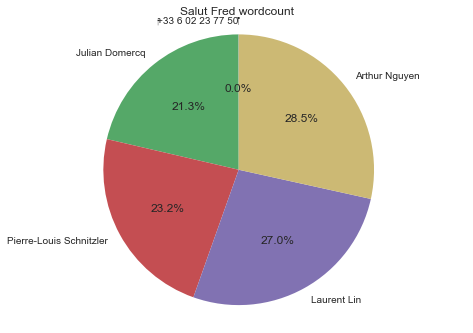

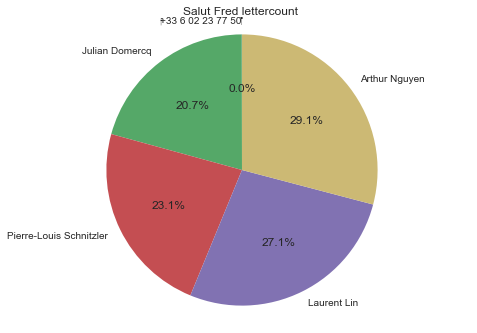

In [11]:
grouped = df.groupby('member')

sizes = grouped[['member', 'wordcount']].sum().sort_values('wordcount')
fig1, ax1 = plt.subplots()
ax1.pie(sizes, autopct='%1.1f%%', labels = sizes.index, startangle=90)
ax1.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Salut Fred wordcount')
plt.show()

sizes = grouped[['member', 'lettercount']].sum().sort_values('lettercount')
fig1, ax1 = plt.subplots()
ax1.pie(sizes, autopct='%1.1f%%', labels = sizes.index, startangle=90)
ax1.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Salut Fred lettercount")
plt.show()

## b : Wordcount and lettercount per person by datetime

Part 2 : total word count, letter count per person by datetime


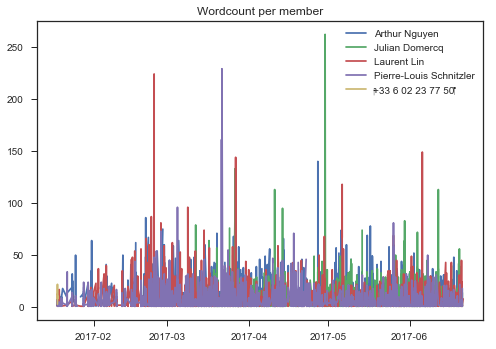

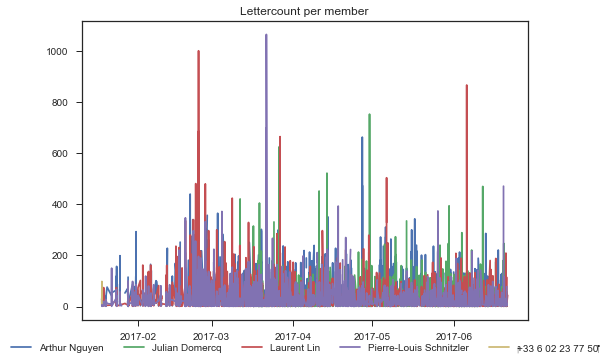

In [12]:
plt.figure()
for key, grp in df.groupby(['member']):
    #print(key) # name of member
    #print(grp) # everything the member said
    plt.plot(grp['wordcount'], label=key)
plt.legend(loc='best')
plt.title('Wordcount per member')    
plt.show()

plt.figure()
for key, grp in df.groupby(['member']):
    plt.plot(grp['lettercount'], label=key)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=5)
plt.title('Lettercount per member')    
plt.show()


## c : Wordcound, lettercount per day

Switch between lettercount and wordcount.

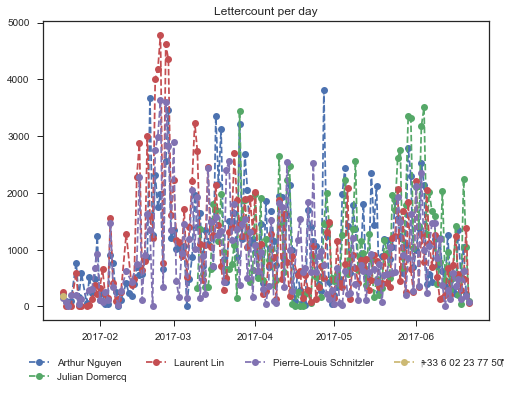

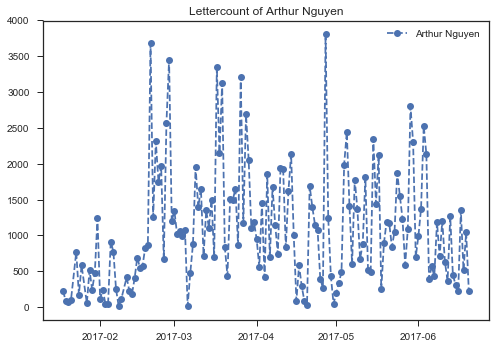

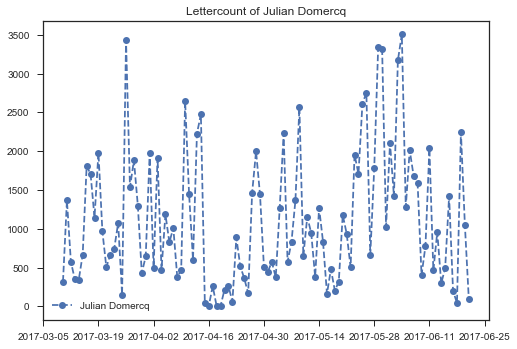

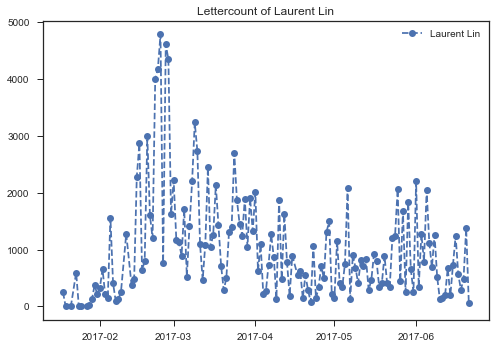

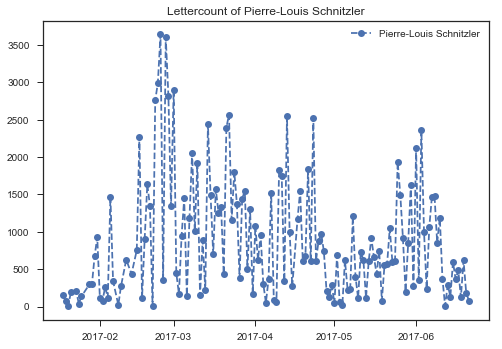

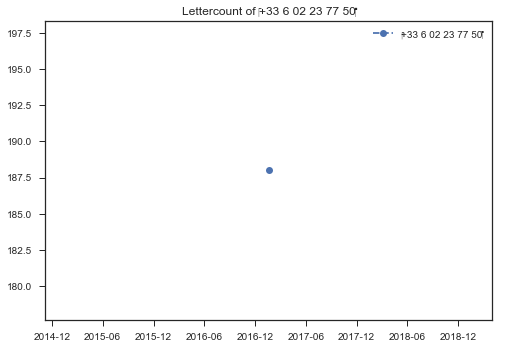

In [15]:
df2 = df.groupby(['member'])['lettercount'].resample('1D').sum().dropna(axis=0,
                how='any').reset_index()
# reset_index drops the multi-index
plt.figure()
for key, grp in df2.groupby(['member']):
    plt.plot(grp['datetime'], grp['lettercount'], label = key,
             linestyle = 'dashed', marker = 'o')
#plt.legend(loc='best')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
           fancybox=False, shadow=False, ncol=4)
plt.title('Lettercount per day')
plt.show()


# One graph for each member
for key, grp in df2.groupby(['member']):
    plt.figure()
    plt.plot(grp['datetime'], grp['lettercount'], label = key,
             linestyle = 'dashed', marker = 'o')
    plt.legend(loc = 'best')
    plt.title("Lettercount of "+ key)
    plt.show()

# Part 2 : Different types of messages

In [61]:
# Most active days
print('Most active day :', df2.groupby(['datetime'])['datetime','lettercount'].sum().idxmax()) 
# by member
print(df2.ix[list(df2.groupby(['member'])[['lettercount']].idxmax()['lettercount'])])
# single member
selected_member = "Laurent Lin"
print('Most active day for', selected_member,
      df2.ix[df2[df2.member == selected_member]['lettercount'].idxmax()]['datetime'])
# days were total number of messages > threshold

Most active day : lettercount   2017-02-26
dtype: datetime64[ns]
                      member   datetime  lettercount
96             Arthur Nguyen 2017-04-27       3805.0
237           Julian Domercq 2017-06-04       3505.0
287              Laurent Lin 2017-02-24       4789.0
434  Pierre-Louis Schnitzler 2017-02-24       3640.0
551      ‪+33 6 02 23 77 50‬ 2017-01-18        188.0
Most active day for Laurent Lin 2017-02-24 00:00:00


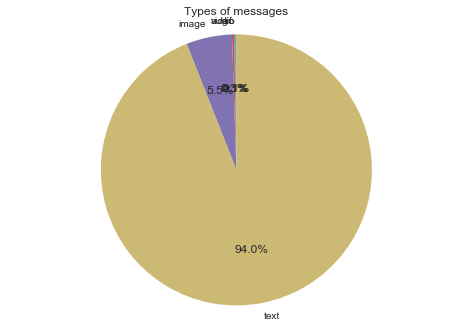

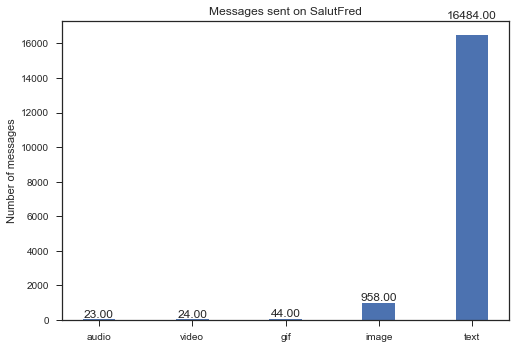

In [62]:
# Pie chart version
sizes = df.groupby('type')[['type']].count().sort_values('type')
sizes.columns = ['Count']
plt.figure()
plt.pie(sizes, autopct='%1.1f%%', labels = sizes.index, startangle=90)
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Types of messages')
plt.show()

# Bar plot version
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    
    Source : https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.2f' % height, # '%d' % int(height), if int precision only
                ha='center', va='bottom')        
plt.figure()
barplot = plt.bar(range(len(sizes.index)), height = sizes['Count'], width = 0.35)
plt.xticks(range(len(sizes.index)), sizes.index)
plt.title('Messages sent on ' + chatname)
plt.ylabel('Number of messages')
autolabel(barplot)
plt.show()






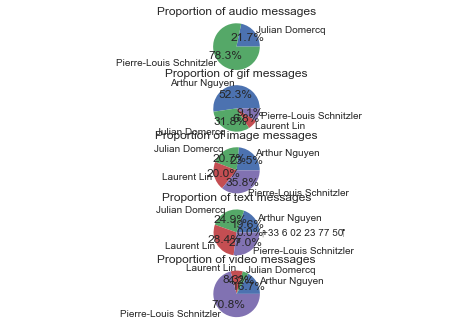

In [63]:
# plot by member
df3 = df.groupby(['member','type'])[['type']].count() # by member
df3.columns = ['Count']
df3 = df3.reset_index()
n_member = df3['member'].drop_duplicates().count() # number of members
n_type = df3['type'].drop_duplicates().count() # number of types of messages
f, axarr = plt.subplots(n_type, 1) # Initialize figure
iterator = 0
for type_key, type_grp in df3.groupby(['type']):
    axarr[iterator].pie(
            type_grp['Count'], 
            autopct='%1.1f%%', 
            labels = type_grp['member'])
    axarr[iterator].axis('equal')
    axarr[iterator].set_title("Proportion of " + type_key + " messages",
         fontsize = 12)
    iterator = iterator + 1
plt.show()

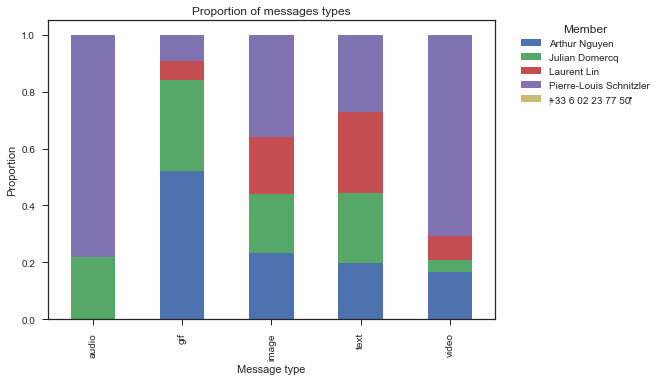

In [64]:
# Change into stacked bar plot
right = df3.groupby(['type'])[['Count']].sum()
right.columns = ['Type_count']
right = right.reset_index()
merged = pd.merge(df3, right, how = 'left', on = ['type'])
merged = merged.assign(proportion = merged.Count/merged.Type_count
                       )[['member', 'type', 'proportion']]
merged = merged.pivot(index = 'type',
                      columns = 'member', 
                      values = 'proportion')
plt.figure()
merged.plot(kind = 'bar', 
            stacked = True, 
            title = 'Proportion of messages types')
#plt.legend(title = 'Member', loc = 'best')
plt.legend(title = "Member", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Message type")
plt.ylabel("Proportion")
plt.show()

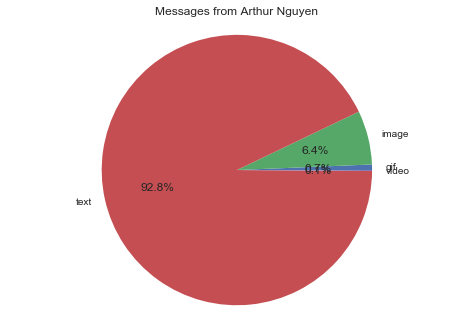

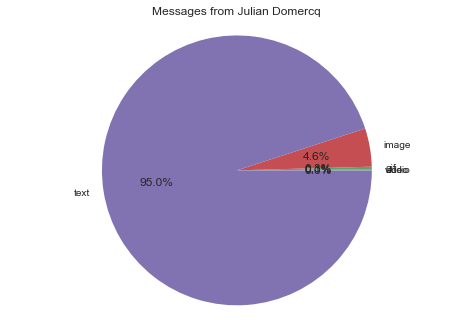

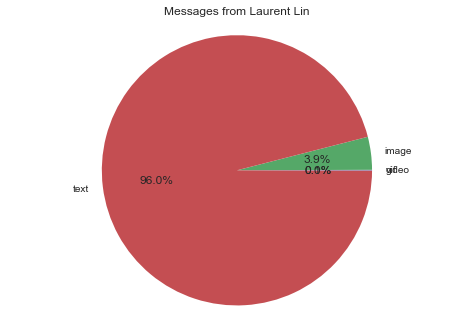

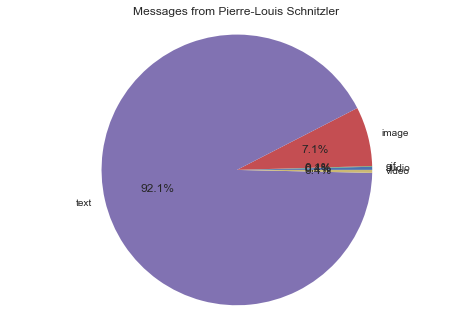

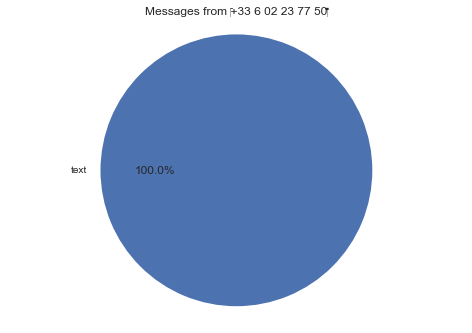

In [65]:
# Group by member
# Pie chart version 
for member_key, member_grp in df3.groupby(['member']):
    plt.figure()
    plt.pie(member_grp['Count'], autopct='%1.1f%%', 
            labels = member_grp['type'])
    plt.axis('equal')
    plt.title("Messages from " + member_key)
    plt.show()

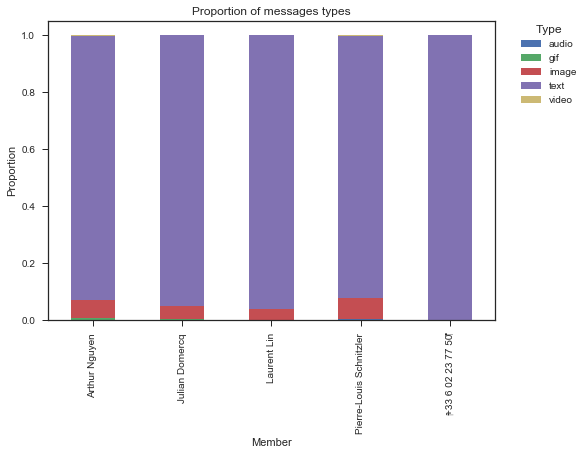

In [66]:
# Stacked bar plot version
right = df3.groupby(['member'])[['Count']].sum()
right.columns = ['Type_count']
right = right.reset_index()
merged = pd.merge(df3, right, how = 'left', on = ['member'])
merged = merged.assign(proportion = merged.Count/merged.Type_count
                       )[['member', 'type', 'proportion']]
merged = merged.pivot(index = 'member',
                      columns = 'type', 
                      values = 'proportion')
merged.plot(kind = 'bar', 
            stacked = True, 
            title = 'Proportion of messages types')
plt.legend(title = "Type", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Member")
plt.ylabel("Proportion")
plt.show()

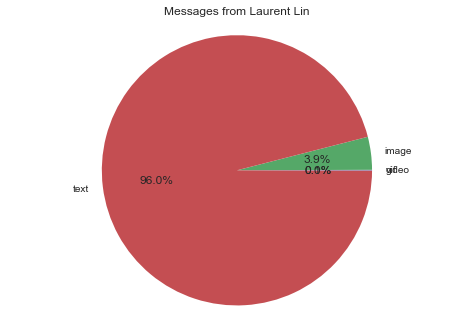

In [67]:
# for only one member
selected_member = "Laurent Lin"
plt.figure()
plt.pie(df3[df3.member == selected_member]['Count'], 
        autopct='%1.1f%%', 
        labels = df3[df3.member == selected_member]['type'])
plt.axis('equal')
plt.title("Messages from " + selected_member)
plt.show()

# Part 3 : concerning average words per message

In [69]:
# Average words, messages in total
word_bymember = grouped[['member', 
                           'wordcount']].sum(
                           ).sort_values('wordcount')
n_msg = df.groupby('type')[[
        'type']].count().sort_values('type').loc['text']
print("In total", n_msg.iloc[0], "messages")
print("Average number of words per message =", 
      float(word_bymember.sum()/int(n_msg)))


In total 16484 messages
Average number of words per message = 7.822069885950012


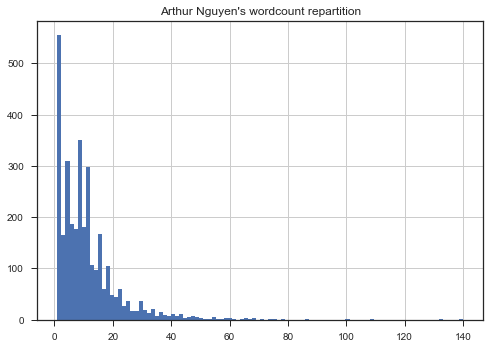

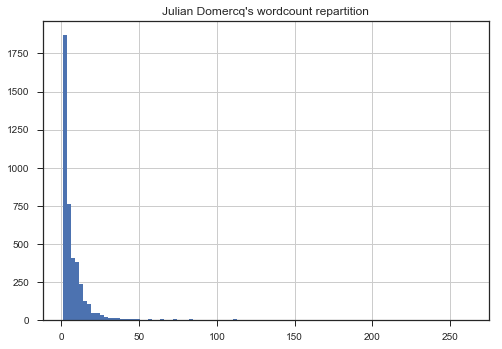

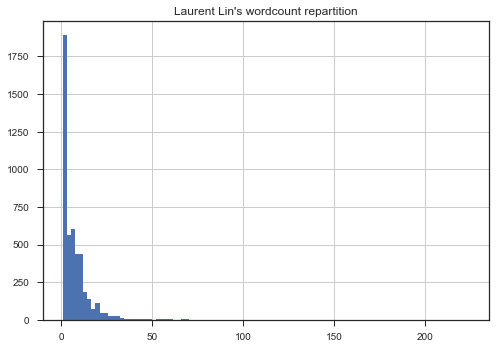

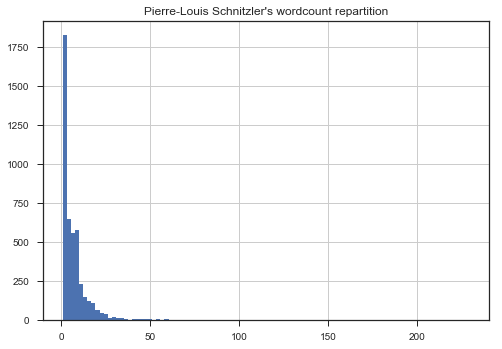

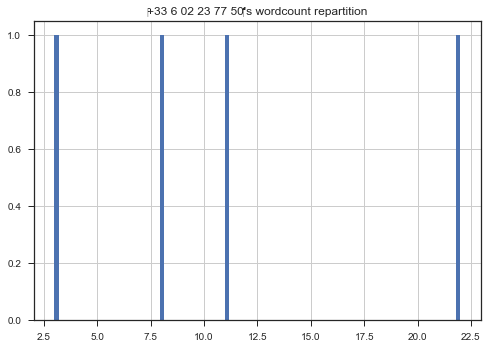

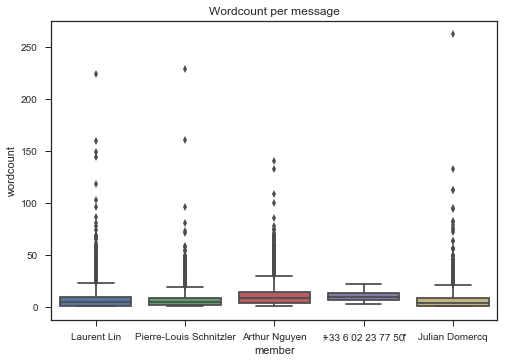

In [79]:
# Stats of wordcount
# Histogram
for key, grp in df.groupby(['member']):
    plt.figure()
    grp[["wordcount"]].hist(bins =100)
    plt.title(key + "\'s wordcount repartition")
    plt.show()
# Boxplot
plt.figure()
sns.boxplot(x = 'member', y = 'wordcount', 
            data = df).set_title("Wordcount per message")
plt.show()

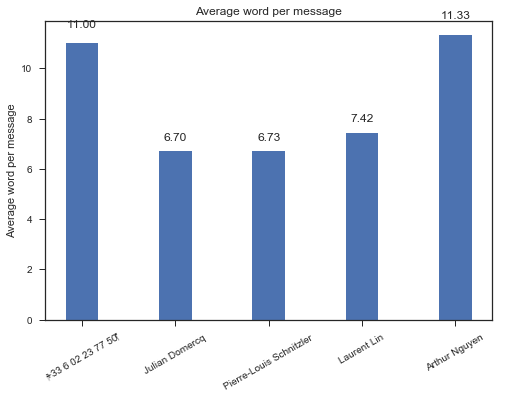

In [72]:
# Average word per message by member
msg_bymember = df.groupby(['type',
                           'member'
                           ])[['type']].count().sort_values('type')
msg_bymember.columns = ['msg_count']
msg_bymember = msg_bymember.reset_index()
msg_bymember = pd.merge(
        word_bymember.reset_index(), 
        msg_bymember[msg_bymember.type == 'text'].drop('type', axis = 1),
        how = 'left', on = ['member'])
msg_bymember = msg_bymember.assign(
        avg_word = msg_bymember.wordcount/msg_bymember.msg_count)


# Barplot with autolabel
plt.figure()
barplot = plt.bar(range(len(msg_bymember.index)), 
                  height = msg_bymember['avg_word'], width = 0.35)
plt.title("Average word per message")
plt.xlabel("")
plt.xticks(range(len(msg_bymember.index)), 
           msg_bymember.member,
           rotation = 30)
plt.ylabel("Average word per message")
autolabel(barplot)
plt.show()

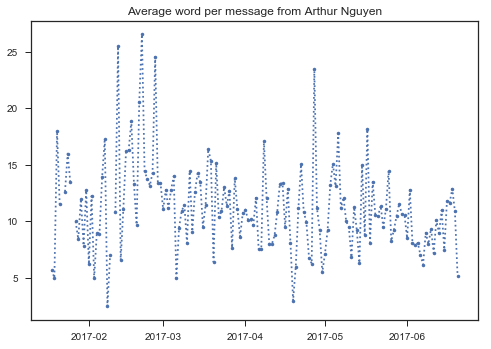

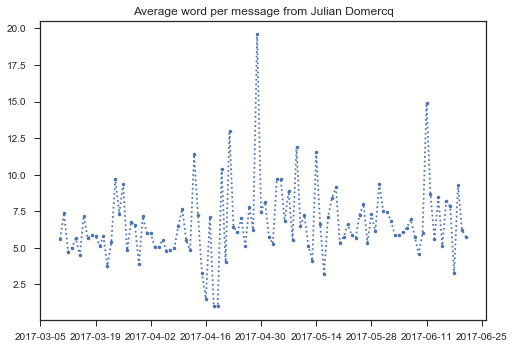

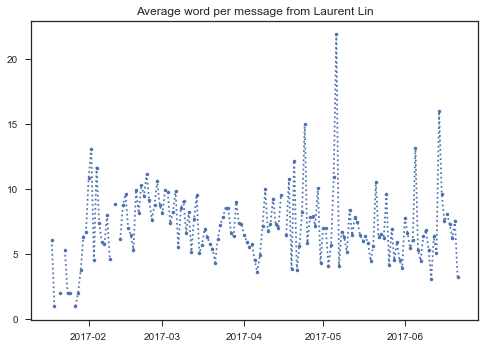

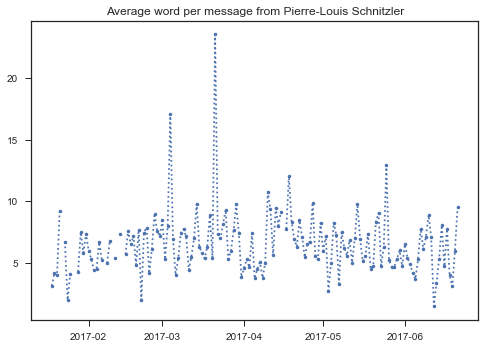

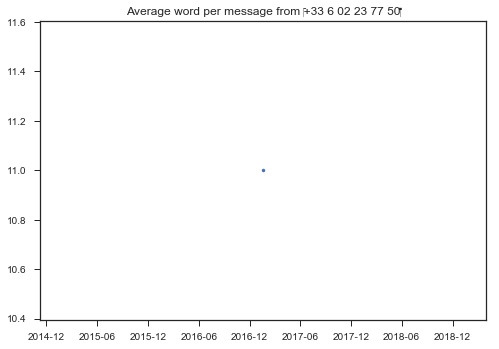

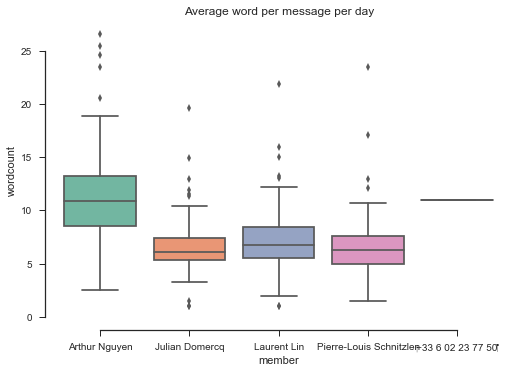

In [73]:
# Wordcount per day per member
df.groupby(['member'])[['wordcount']].resample('1D').sum().reset_index()
# Average word per message per day
df4 = df.groupby(['member'])[['wordcount']].resample('1D').mean().reset_index()
# Number of message per member per day
df5 = df.groupby(['member'])[['wordcount']].resample('1D').count()
df5.columns = ["Count"]
df5 = df5.reset_index()
# Plot as function of time
for key, grp in df4.groupby(['member']):
    plt.figure()
    plt.plot(grp['datetime'], grp['wordcount'], label = key,
             linestyle = ':', marker = '.')
    plt.title("Average word per message from " + key)
    plt.show()
# Boxplot
plt.figure()
sns.boxplot(x = "member", y = "wordcount", data = df4, palette = sns.color_palette("Set2")).set_title(
        "Average word per message per day")
plt.xticks(rotation = 30)
sns.despine(offset=10, trim=True)
plt.show()

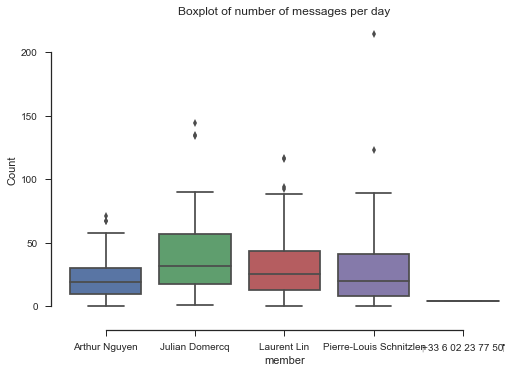

In [78]:
# Boxplot with messages per day
plt.figure()
sns.boxplot(x = "member", y = "Count", data = df5)
plt.title("Boxplot of number of messages per day")
plt.xticks(rotation = 30)
sns.despine(offset=10, trim=True)
plt.show()

# Part 4 : Concerning time laps between messages ("bide")

In [82]:
# Sort to avoid negative bides
df_sorted = df.reset_index().sort_values(['datetime'], ascending = True)

shifted = df_sorted.shift(-1)[["datetime", 'content', 'member', 'type']]
shifted.columns = ["shifted_datetime", "msg_postbide",
                   "member_postbide", 'type_postbide']
shifted = pd.concat([df_sorted, shifted], axis = 1)
shifted = shifted.assign(bide = shifted.shifted_datetime - shifted.datetime)
shifted = shifted.assign(auto_debidage = 
                         (shifted.member == shifted.member_postbide))
# auto_debidage : True if following message is from same user
shifted = shifted.assign(s_bide = shifted.bide.astype('timedelta64[s]'))
# search largest bides
shifted.nlargest(10, 'bide')[
        ['datetime', 'member', 'bide', 'content', 
         'member_postbide', 'msg_postbide', 'type_postbide', 'auto_debidage']]    


,datetime,member,bide,content,member_postbide,msg_postbide,type_postbide,auto_debidage
643,2017-02-09 22:20:04,Laurent Lin,1 days 20:25:52,Matlab aussi,Pierre-Louis Schnitzler,None,image,False
62,2017-01-21 23:47:47,Pierre-Louis Schnitzler,1 days 18:51:26,😣,Laurent Lin,alors ce dernier cours avec Artie,text,False
53,2017-01-20 06:26:58,Pierre-Louis Schnitzler,1 days 16:38:04,Je ne sais pas.,Arthur Nguyen,Vous avez remarqué les deux cavaliers de carre...,text,False
189,2017-01-28 08:07:31,Laurent Lin,1 days 14:11:33,Ah ok,Laurent Lin,Sur la première photo de Marion c'est le cousi...,text,True
143,2017-01-25 18:23:46,Pierre-Louis Schnitzler,1 days 06:47:30,😂😂😂,Pierre-Louis Schnitzler,None,image,True
1097,2017-02-17 20:01:39,Laurent Lin,1 days 02:51:25,pareil..,Laurent Lin,Premier karaoké à Hong Kong ! C'était bien mai...,text,True
146,2017-01-27 01:12:09,Laurent Lin,1 days 00:14:15,😘Dautremerde,Arthur Nguyen,Aviez-vous remarqué que la couleur du projet i...,text,False
783,2017-02-14 00:59:06,Laurent Lin,0 days 22:57:52,Pour SF j'ai envoyé un mail et j'attends la ré...,Arthur Nguyen,Pathétiques les vidéos qu'on a tournées en all...,text,False
406,2017-02-04 00:33:20,Pierre-Louis Schnitzler,0 days 22:37:04,C'est ta mère sur la fontaine Arthur?,Laurent Lin,C'est bizarre sur la page Fb ils disent que no...,text,False
355,2017-02-01 22:02:04,Laurent Lin,0 days 21:46:37,du coup mon voisin il a déjà fait une thèse ap...,Laurent Lin,Il y a un mec qui a fait un Bachelor de biochi...,text,True


In [85]:
bide_min = pd.Timedelta('5 hours')
# General information
print(shifted['bide'].describe())
# bide bigger larger than bide_min
print(shifted[shifted.bide > bide_min].sort_values(['bide'], ascending = False))

count                     17532
mean     0 days 00:12:39.610141
std      0 days 01:15:47.801843
min             0 days 00:00:00
25%             0 days 00:00:12
50%             0 days 00:00:31
75%             0 days 00:01:45
max             1 days 20:25:52
Name: bide, dtype: object
                 datetime                   member  \
643   2017-02-09 22:20:04              Laurent Lin   
62    2017-01-21 23:47:47  Pierre-Louis Schnitzler   
53    2017-01-20 06:26:58  Pierre-Louis Schnitzler   
189   2017-01-28 08:07:31              Laurent Lin   
143   2017-01-25 18:23:46  Pierre-Louis Schnitzler   
1097  2017-02-17 20:01:39              Laurent Lin   
146   2017-01-27 01:12:09              Laurent Lin   
783   2017-02-14 00:59:06              Laurent Lin   
406   2017-02-04 00:33:20  Pierre-Louis Schnitzler   
355   2017-02-01 22:02:04              Laurent Lin   
374   2017-02-02 20:48:36              Laurent Lin   
724   2017-02-12 03:13:47            Arthur Nguyen   
608   2017-02-07

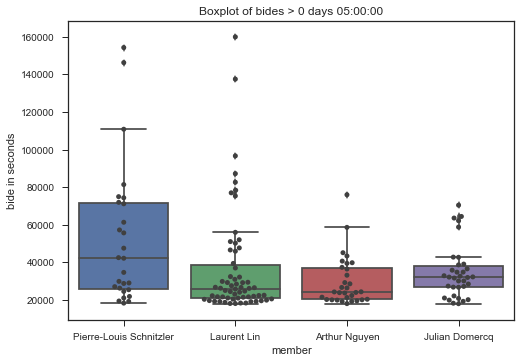

In [84]:
# Plot bides larger than bide_min
plt.figure()
sns.boxplot(x = 'member', y = 's_bide', 
            data = shifted[shifted.bide > bide_min])
sns.swarmplot(x = 'member', y = 's_bide', 
              data = shifted[shifted.bide > bide_min],
              color = '.25')
plt.title('Boxplot of bides > ' + str(bide_min))
plt.ylabel('bide in seconds')
plt.show()

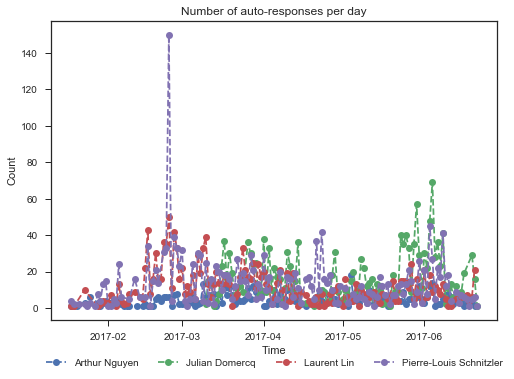

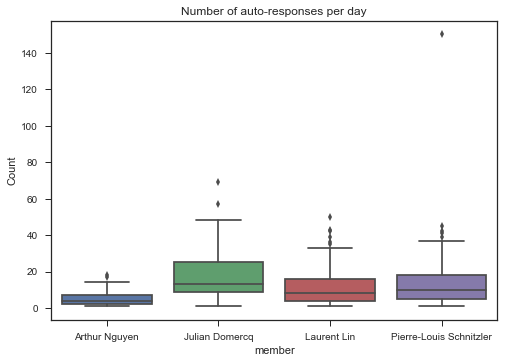

In [88]:
# Number of auto_rep
# Consecutive messages = a_rep
shifted2 = df_sorted.shift(1)[["datetime", 'content', 'member', 'type']]
shifted2.columns = [
        "shifted_datetime", 
        "msg_prebide",
        "member_prebide", 
        'type_prebide'
        ]
shifted2 = pd.concat([df_sorted, shifted2], axis = 1)
shifted2 = shifted2.assign(
        auto_responding = (shifted2.member == shifted2.member_prebide)
        )
shifted2['block'] = (
        shifted2['auto_responding'] != shifted2['auto_responding'].shift(1)
        ).astype(int).cumsum()
shifted2['block_cumcount'] = shifted2[
        ['auto_responding', 'block']
        ].groupby('block').transform(lambda x: list(range(1, len(x) + 1)))
shifted2 = shifted2.assign(
        a_rep = shifted2.auto_responding * shifted2.block_cumcount
        )   
#shifted2[
#        ['member', 'auto_responding', 'block', 'block_cumcount', 'a_rep']
#        ].nlargest(50, 'a_rep')

shifted2['a_rep_count'] = shifted2[
        ['block', 
         'auto_responding']
        ].groupby(
        'block'
        ).transform(
                lambda x: len(x)
                )
# For a same auto responding block a_rep_count displays the same value
# So we need to drop dupicates
shifted2 = shifted2.query(
        '(auto_responding == True)'
        ).drop_duplicates(
                subset = [
                'member', 'auto_responding', 
                'block', 'a_rep_count'])

shifted2 = shifted2.set_index(
        keys = 'datetime'
        ).groupby(
                ['member']
                )['a_rep_count'].resample('1D').sum().dropna(
                        axis=0, 
                        how='any'
                        ).reset_index()
# plot
plt.figure()
for key, grp in shifted2.groupby(['member']):
    plt.plot(grp['datetime'], grp['a_rep_count'], label = key,
             linestyle = 'dashed', marker = 'o')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
           fancybox=False, shadow=False, ncol=4)
plt.title('Number of auto-responses per day')
plt.xlabel('Time')
plt.ylabel('Count')
plt.show()
# Boxplot
plt.figure()
sns.boxplot(x = 'member', y = 'a_rep_count', data = shifted2)
plt.ylabel("Count")
plt.title('Number of auto-responses per day')
plt.show()

# Part 5 : lol

In [91]:
pd.Series(
        ['1', 'lol', 'test', 'looool', 
           'je suis', 'logiciel','lgociel'
           'mdrtr', 'lol loool', 'lol lol lol',
           'looool loul lol', 'lllloooool', 
           'trolooolol', 'lololol', 'lllooolll',
           'Lol']
        ).str.findall(r'\w*l*lo+o*l+\w*')
# Current formula is not case sensitive

0                  []
1               [lol]
2                  []
3            [looool]
4                  []
5                  []
6                  []
7        [lol, loool]
8     [lol, lol, lol]
9       [looool, lol]
10       [lllloooool]
11       [trolooolol]
12          [lololol]
13        [lllooolll]
14                 []
dtype: object

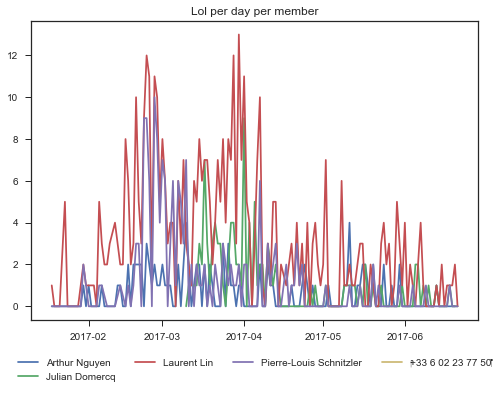

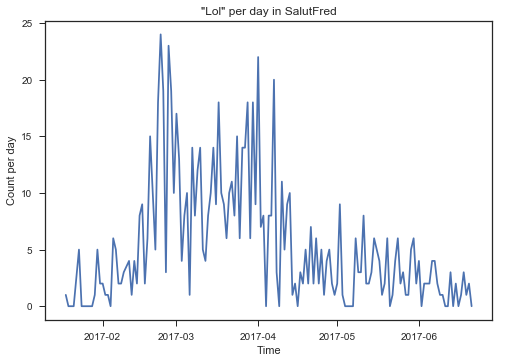

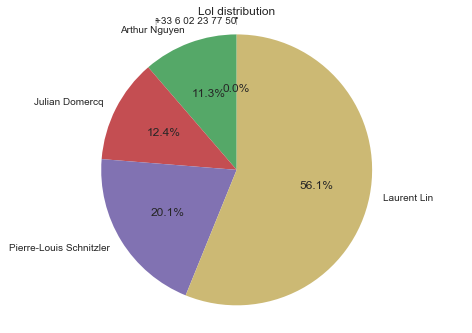

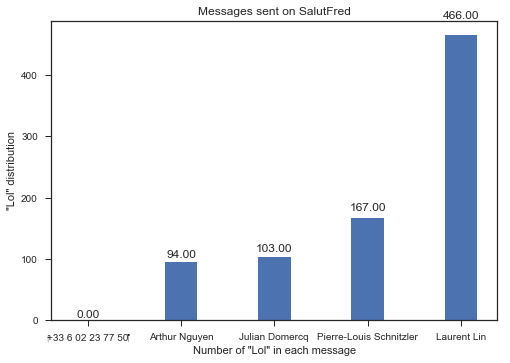

,content,member,lol,lol_form
datetime,,,,
2017-01-18 05:57:00,lol....,Laurent Lin,1.0,[lol]
2017-01-23 18:43:32,lol cool comme cours...,Laurent Lin,1.0,[lol]
2017-01-23 19:02:01,lol ce shotgun,Laurent Lin,1.0,[lol]
2017-01-23 21:21:42,lol,Laurent Lin,1.0,[lol]
2017-01-23 21:25:26,lol sérieux..,Laurent Lin,1.0,[lol]
2017-01-23 21:29:14,lol,Laurent Lin,1.0,[lol]
2017-01-29 23:00:20,lol,Laurent Lin,1.0,[lol]
2017-01-30 01:28:54,"lol, passations sans les gpas ? :p",Arthur Nguyen,1.0,[lol]
2017-01-30 01:31:10,lol ^^,Pierre-Louis Schnitzler,1.0,[lol]


In [92]:
df['content'] = df['content'].str.lower()
df['lol'] = df['content'].str.findall(r'\w*l*lo+o*l+\w*').str.len()
df['lol_form'] = df['content'].str.findall(r'\w*l*lo+o*l+\w*')

df_lol = df.groupby(['member'])['lol'].resample('1D').sum().dropna(axis=0, 
          how='any').reset_index()

plt.figure()
for key, grp in df_lol.groupby(['member']):
    plt.plot(grp['datetime'], grp['lol'], label = key)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
           fancybox=False, shadow=False, ncol=4)
plt.title('Lol per day per member')
plt.show()

df_lol2 = df['lol'].resample('1D').sum().dropna(axis=0, how='any').reset_index()
df_lol2.describe()
plt.figure()
plt.plot(df_lol2['datetime'], df_lol2['lol'])
plt.xlabel('Time')
plt.ylabel('Count per day')
plt.title('"Lol" per day in ' + chatname)
plt.show()

sizes = df.groupby('member')[['lol']].sum()
sizes.columns = ['Lol percentage']
sizes = sizes.sort_values('Lol percentage')
plt.figure()
plt.pie(sizes, autopct='%1.1f%%', labels = sizes.index, startangle=90)
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Lol distribution')
plt.show()

plt.figure()
barplot = plt.bar(range(len(sizes.index)), height = sizes['Lol percentage'], width = 0.35)
plt.xticks(range(len(sizes.index)), sizes.index)
plt.title('Messages sent on ' + chatname)
plt.xlabel('Number of "Lol" in each message')
plt.ylabel('"Lol" distribution')
autolabel(barplot)
plt.show()

In [95]:
df['lol'].describe()
df[df.lol > 0][['content', 'member', 'lol', 'lol_form']]

,content,member,lol,lol_form
datetime,,,,
2017-01-18 05:57:00,lol....,Laurent Lin,1.0,[lol]
2017-01-23 18:43:32,lol cool comme cours...,Laurent Lin,1.0,[lol]
2017-01-23 19:02:01,lol ce shotgun,Laurent Lin,1.0,[lol]
2017-01-23 21:21:42,lol,Laurent Lin,1.0,[lol]
2017-01-23 21:25:26,lol sérieux..,Laurent Lin,1.0,[lol]
2017-01-23 21:29:14,lol,Laurent Lin,1.0,[lol]
2017-01-29 23:00:20,lol,Laurent Lin,1.0,[lol]
2017-01-30 01:28:54,"lol, passations sans les gpas ? :p",Arthur Nguyen,1.0,[lol]
2017-01-30 01:31:10,lol ^^,Pierre-Louis Schnitzler,1.0,[lol]


# Part 6 : emojis 😁

In [96]:
def emoji_count(df):
    import emojis
    from collections import Counter
    df = pd.DataFrame(df['content'], columns = ['content'])
    content_sum = []
    for msg in list(df.dropna(axis=0, how='any')['content'].str.split(' ')):
        for word in msg:
            content_sum += word
    content_sum = Counter(content_sum) # Count of every letter/emoji/chinese caracter 
    emojis_list = emojis.generate_emojis()
    # select only emojis :
    for emoji in emojis_list:
        if not emoji in content_sum :
            emojis_list.remove(emoji)
            # remove an emoji that was not encountered 
            # but there are still emojis with 0 appearance...
    content_sum = {emoji : content_sum[emoji] for emoji in emojis_list}
    emojis_list = pd.Series(content_sum, 
                            name = 'Count').sort_values(ascending = False)
    emojis_list = pd.DataFrame(emojis_list).query('Count > 0')
    return(emojis_list)

In [110]:
# print(emoji_count(df).head(10)) # top 10
print('Total number of emojis =',emoji_count(df).sum().iloc[0]) # total number of emojis
print('Emojis from', selected_member, ':\n', emoji_count(df[df['member'] == selected_member]))

Total number of emojis = 8328
Emojis from Laurent Lin :
     Count
🤔      92
😱      84
😁      77
😅      57
😭      57
😂      51
👏      43
🤣      40
🤐      39
👍      37
️      32
‍      30
#      29
🤦      28
♂      28
😰      27
😎      22
*      21
👌      16
💪      15
😈      13
😨       8
😃       6
😓       6
😊       5
💤       5
😘       5
🙁       5
😕       5
👿       4
..    ...
🇱       1
❤       1
🎤       1
🕴       1
😴       1
🏃       1
🚌       1
💲       1
😀       1
🅿       1
🗾       1
🐌       1
🐢       1
🔑       1
🤧       1
🦈       1
🦁       1
🤡       1
🍓       1
🤗       1
🤓       1
🌋       1
👁       1
😟       1
🎉       1
😡       1
👊       1
👋       1
♠       1
💻       1

[90 rows x 1 columns]


Future releases :
- Compare two conversations